# Sketching with quantized contributions

This notebook illustrates how the sketch contributions can be quantized at essentially no cost. The setting we focus on is almost identical to the experiment reported in the paper [1], where further details on the approach can be found. More precisely, we consider the task of compressive *k-means*, and show how the optimization landscapes (and the associated solution) changes when the sketch contributions are quantized. 

More precisely, the code below produces three plots, which are all based on one synthetically generated 2-D dataset *(blue dots)*. The surface plot *(green)* shows the criterion $\langle \boldsymbol z, \Phi(\boldsymbol c) \rangle$ which is used to select the first centroid $\boldsymbol c$ as initialization step of the CLOMP algorithm (which solves compressive k-means from the sketch). When applicable, the compressively learned centroids, as obtained by the full CLOMP algorithm, are also showed *(red dots)*. 
From left to right:
-  The full-precision case $\langle \boldsymbol z_{\mathrm{RF}}, \Phi_{\mathrm{RF}}(\boldsymbol c) \rangle$, i.e., both the sketch contributions and test centroid $\boldsymbol c$ use the full-precision random Fourier features $\Phi_{\mathrm{RF}}$ (we assume that floating-point numbers are encoded with 64 bits).
- The "semi-quantized" criterion $\langle \boldsymbol z_{q}, \Phi_{\mathrm{RF}}(\boldsymbol c) \rangle$, where the sketch $\boldsymbol z_{q}$ use quantized contributions, but the the centroid use full-precision random Fourier features.
- The fully quantized cost $\langle \boldsymbol z_{q}, \Phi_{q}(\boldsymbol c) \rangle$, where all features are quantized. Note that this cost cannot be solved with CLOMP (as it is not differentiable), which is why no red dots are shown. We can also observe that the required $m$ is in this case usually significantly larger.


You can play around with some parameters: the random seed, the number of clusters $k$, as well as the sketch size ($m$) and its scale parameter ($\sigma$).

> [1] Rémi Gribonval, Antoine Chatalic, Nicolas Keriven, Vincent Schellekens, Laurent Jacques, and Philip Schniter, "Sketching Datasets for Large-Scale Learning", [ArXiv](https://arxiv.org/abs/2008.01839).


In [1]:
%matplotlib notebook

# General imports
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import scipy.stats

# Interactive widget
from ipywidgets import widgets, interact

# We import the pycle toolbox for sketched learning; we will need three submodules
import pycle
from pycle import sketching, compressive_learning, utils

# Plot utilities
from plot_utils import do_the_plot_for_notebook_3

In [2]:
# f_cost_R is the true statistical learning cost
# f_cost_L is the sketched cost

def f_cost_R(th_0,th_1,X):
    return pycle.utils.SSE(X,np.array([[th_0,th_1]]))
    
def f_cost_L(th_0,th_1,z,Phi):
    return np.linalg.norm(z - Phi(np.array([[th_0,th_1]]))) 


<IPython.core.display.Javascript object>


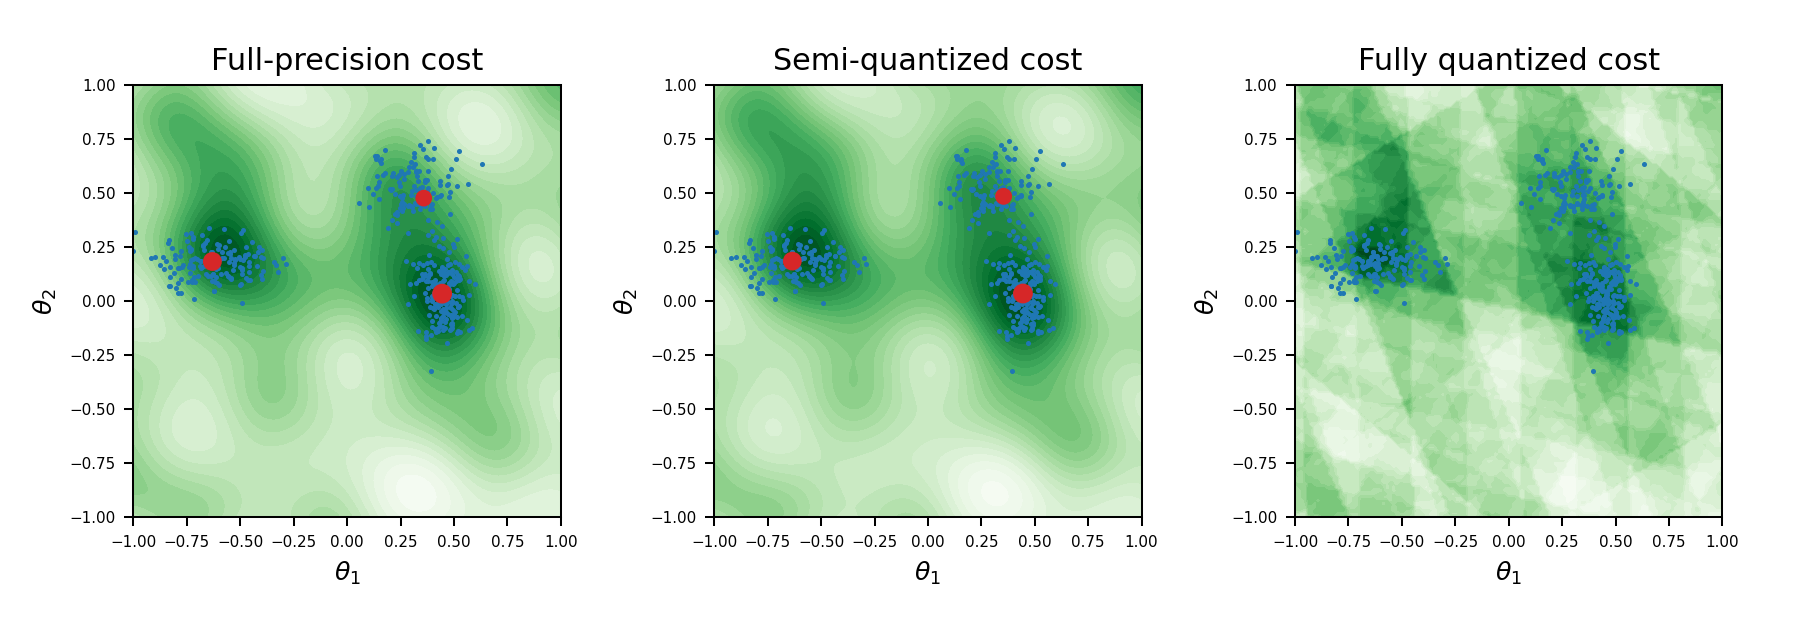

interactive(children=(IntSlider(value=42, continuous_update=False, description='random seed'), IntSlider(value…

In [3]:
d = 2

seeds = widgets.IntSlider(value=42, min=0, max=100,step=1, description='random seed', continuous_update=False)
ks    = widgets.IntSlider(value=3, min=1, max=5,step=1, description='$k$', continuous_update=False)

ms     = widgets.FloatLogSlider(value=20, min=0, max=3,step=0.1, description='$m$', continuous_update=False)
sigmas = widgets.FloatLogSlider(value=0.2,min=-3,max=2,  step=0.1, description='$\sigma$', continuous_update=False)

fig = plt.figure(figsize=(10,3.5))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)
fig.tight_layout(pad=3)

# plotting parameters
ballsize = 120
markersize = 20
lw = 1.5
nLines = 30
cR = 'tab:blue'
cL = 'tab:red'
s = 1

ticksize = 6
plt.rc('xtick',labelsize=ticksize)
plt.rc('ytick',labelsize=ticksize)

@interact(seed=seeds,k=ks,m=ms,sigma=sigmas)
def _(seed,k,m,sigma):
    

    
    m = int(m)
    print("sketch size m = " + str(m))
    
    # Print params
    print(f"\tfull-precision sketch contributions: {128*m} bits")
    print(f"\tquantized sketch contributions: {2*m} bits")
    
    np.random.seed(seed)
    n = int(5e2) # Number of samples we want to generate
    X = pycle.utils.generatedataset_GMM(d,k,n,normalize='l_inf-unit-ball',balanced=False, separation_min=2) 
    
    # Sketch
    sigma2 = sigma**2

    W = pycle.sketching.drawFrequencies("Gaussian",d,m,sigma2)
    xi = pycle.sketching.drawDithering(m) # dithering vector
    
    # full-precision and quantized sketch feature map
    Phi   = pycle.sketching.SimpleFeatureMap("ComplexExponential",W,xi,c_norm=1/np.sqrt(m))
    Phi_q = pycle.sketching.SimpleFeatureMap("universalquantization_complex",W,xi,c_norm=2/(np.pi*np.sqrt(m)))

    z   = pycle.sketching.computeSketch(X,Phi)
    z_q = pycle.sketching.computeSketch(X,Phi_q)
    
    # Bounds
    low_pos = -1
    upp_pos = +1
    bounds = np.array([low_pos*np.ones(d),upp_pos*np.ones(d)])

    nTest = 131

    # Params to test
    thetas_00 = np.linspace(low_pos,upp_pos,nTest)
    thetas_11 = np.linspace(low_pos,upp_pos,nTest)

    thetas_0,thetas_1 = np.meshgrid(thetas_00,thetas_11) 
    
    # Compute the costs everywhere
    cost_EE = np.zeros((nTest,nTest))
    cost_EQ = np.zeros((nTest,nTest))
    cost_QQ = np.zeros((nTest,nTest))

    # Exhaustive loop over the grid
    for i_0,th_0 in enumerate(thetas_00):
        for i_1,th_1 in enumerate(thetas_11):
            cost_EE[i_0,i_1] = f_cost_L(th_0,th_1,z,Phi)
            cost_EQ[i_0,i_1] = f_cost_L(th_0,th_1,z_q,Phi)
            cost_QQ[i_0,i_1] = f_cost_L(th_0,th_1,z_q,Phi_q)

    # Compute the solutions with clomp
    (w_EE,C_EE) = pycle.compressive_learning.CLOMPR("k-means",z,Phi,k,bounds,nRepetitions=3)
    (w_EQ,C_EQ) = pycle.compressive_learning.CLOMPR("k-means",z_q,Phi,k,bounds,nRepetitions=3)
    
    # Create the plots with dedicated function from plot_utils.py
    do_the_plot_for_notebook_3(ax1,ax2,ax3,thetas_0,thetas_1,X,cost_EE,cost_EQ,cost_QQ,C_EE,C_EQ,s,ballsize,w_EE,w_EQ,cR,cL,nLines)



Note that it is expected that the CLOMP solution (red dots) do not always coincide with local minima of the first centroid selection criterion (green surface plot), because
1. In the end, the CLOMP optimization problem considers $K$ centroids together, while the green cost plotted here considers only the first centroid to select;
2. The CLOMP algorithm might fail to converge to the global minimizer of that cost function.